In [45]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from collections import Counter
from transformers import pipeline
import pickle
import matplotlib.pyplot as plt
import nltk

In [46]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [47]:
medium_data = pd.read_csv('medium_data.csv')

In [48]:
medium_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [49]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  6508
Number of fields:  10


In [50]:
medium_data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

In [51]:
# Removing unwanted characters and words in titles

medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

In [52]:
# Word Frequency Analysis
all_words = " ".join(medium_data["title"]).split()
word_freq = Counter(all_words)
print("Most common words:", word_freq.most_common(10))

Most common words: [('to', 1465), ('the', 952), ('a', 910), ('of', 908), ('The', 853), ('How', 832), ('and', 817), ('in', 710), ('Your', 613), ('for', 582)]


In [53]:
# Initialize Tokenizer
tokenizer = Tokenizer(oov_token='<oov>')  # Handles unknown words
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

In [54]:
# Save tokenizer
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle)

In [55]:
print("Total words in vocabulary:", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total words in vocabulary: 8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


In [56]:
# Generate N-gram sequences
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [57]:
# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  48461


In [58]:
# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68])

In [59]:
# Create features and labels
X, labels = input_sequences[:, :-1], input_sequences[:, -1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [60]:
print(X[5])
print(labels[5])
print(y[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14
1.0


In [61]:
# Define Bi-LSTM Model
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [62]:
# Compile Model
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [63]:
# Train Model
history = model.fit(X, y, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 92s 114ms/step - accuracy: 0.0897 - loss: 7.1037
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 94s 125ms/step - accuracy: 0.1752 - loss: 5.7063
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 88s 116ms/step - accuracy: 0.2192 - loss: 4.7919
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 96s 126ms/step - accuracy: 0.2812 - loss: 3.9282
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 99s 131ms/step - accuracy: 0.3567 - loss: 3.2692
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 92s 121ms/step - accuracy: 0.4257 - loss: 2.7706
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 96s 127ms/step - accuracy: 0.4777 - loss: 2.4397
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 96s 126ms/step - accuracy: 0.5187 - loss: 2.1923
Epoch 9/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 93s 123ms/step - accuracy: 0.5442 - loss: 2.0535
Epoch 10/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 92s 121ms/step - accuracy: 0.5590 - loss: 1.9547
Epoch 11/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 100s 132ms/step - accuracy: 0.5801 - loss: 1.8283
Epoch 12/50
758/75

In [64]:
# Plot Training Performance
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Model {metric}")
    plt.show()

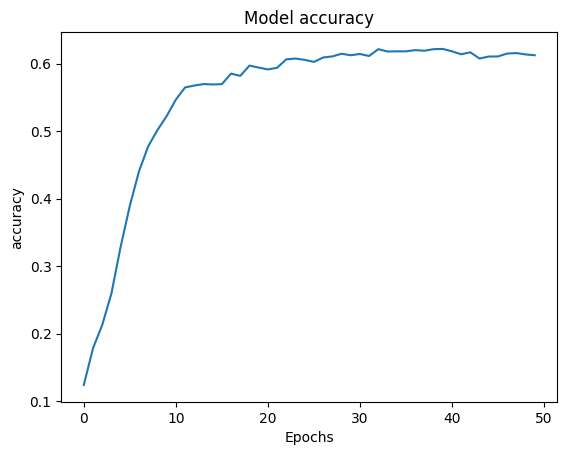

In [65]:
plot_graphs(history, 'accuracy')

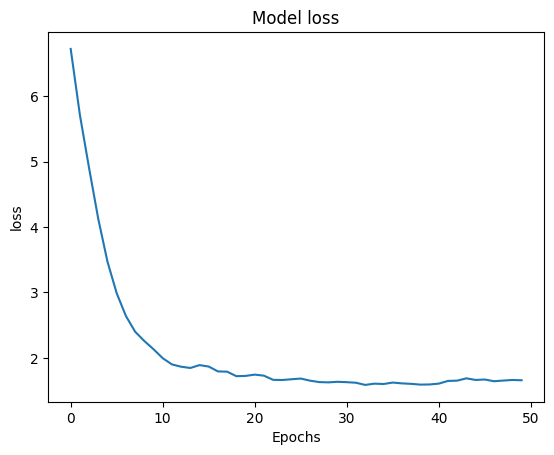

In [66]:
plot_graphs(history, 'loss')

In [67]:
# Save trained model
model.save("lstm_next_word_model.h5")

In [68]:
# Function to Predict Next Word
def predict_next_word(seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probs = model.predict(token_list, verbose=0)
    predicted_index = np.argmax(predicted_probs)

    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            return word
    return ""

In [69]:
pip --quiet install tf-keras


Note: you may need to restart the kernel to use updated packages.


In [70]:
# Function to Predict with BERT
bert_predictor = pipeline("fill-mask", model="bert-base-uncased")

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.
Device set to use 0


In [71]:
def predict_with_bert(text):
    masked_text = text + " [MASK]."
    result = bert_predictor(masked_text)
    return [prediction["token_str"] for prediction in result[:3]]

In [72]:
# Common Phrases Lookup
common_phrases = {
    "machine": ["learning", "intelligence", "vision"],
    "data": ["science", "analytics", "engineering"],
    "artificial": ["intelligence", "neural networks", "learning"],
    "deep": ["learning", "neural networks", "vision"],
}

def get_common_phrase(word):
    return common_phrases.get(word, [])

In [73]:
# Personalization (User Preference Tracking)
user_preferences = {}

def update_user_preferences(word):
    user_preferences[word] = user_preferences.get(word, 0) + 1

In [74]:
# Track Prediction Usage (% of Accepted Words)
accepted_predictions = {"AI": 5, "Data": 3, "Machine": 7}
total_predictions = sum(accepted_predictions.values())
usage_percentage = {word: (count/total_predictions) * 100 for word, count in accepted_predictions.items()}

In [75]:
print("Prediction usage statistics:", usage_percentage)

Prediction usage statistics: {'AI': 33.33333333333333, 'Data': 20.0, 'Machine': 46.666666666666664}


In [76]:
# Test Predictions
print("\n🔹 LSTM Prediction:")
print(f"Input: 'Artificial intelligence is'")
print(f"Prediction: {predict_next_word('Artificial intelligence is')}")

print("\n🔹 BERT Prediction:")
print(f"Input: 'Artificial intelligence is'")
print(f"Predictions: {predict_with_bert('Artificial intelligence is')}")


🔹 LSTM Prediction:
Input: 'Artificial intelligence is'
Prediction: not

🔹 BERT Prediction:
Input: 'Artificial intelligence is'
Predictions: ['possible', 'important', 'fundamental']
